In [1]:
import sys
sys.path.insert(0, '../ghtesting')

from util import *
from tqdm.auto import tqdm
import json
from matplotlib import pyplot as plt
import numpy as np
import subprocess
from scipy.stats import ks_2samp
from macrogen import update_macro

In [2]:
plt.style.use(['science'])

In [3]:
WEBFRAMEWORKS = ['Angular', 'React', 'Vue']
COLORS = ['r', 'b', 'g']

In [4]:
repos = get_repos()

In [5]:
def get_commit_history(git):
    return [log.split()[1] for log in git.git.log().split('\n') if log.startswith('commit')]

def read_file(git, commitid, file):
    try:
        return git.git.show(f'{commitid}:{file}')
    except:
        return ""

def get_ci(readme):
    for service_url, service_name in service_urls.items():
        if re.search(service_url, readme) is not None:
            return service_name

In [6]:
def has_ci(git, commit_id, ci):
    readme = read_file(git, commit_id, 'README.md')
    return get_ci(readme) == ci

In [7]:
def get_first_ci_commit(git, commit_history, current_ci):
    lo = 0
    hi = len(commit_history) - 1
    while lo < hi - 1:
        mid = round((lo + hi) / 2)
        if has_ci(git, commit_history[mid], current_ci):
            hi = mid
        else:
            lo = mid
    if has_ci(git, commit_history[lo], current_ci): return commit_history[lo]
    if has_ci(git, commit_history[mid], current_ci): return commit_history[mid]
    if has_ci(git, commit_history[hi], current_ci): return commit_history[hi]

In [8]:
def ks_test(d1, d2):
    test = ks_2samp(d1, d2)
    return f'{test.statistic:.3f}' + ('*' if test.pvalue < 0.05 else '')

In [9]:
with open('../data/ci_introduction_commit.json') as f:
    ci_introduction = json.load(f)

In [10]:
for repo in tqdm(repos):
    repo_path = get_repository_path(repo)
    
    git = Repo(repo_path)
    
    if repo.name in ci_introduction:
        continue
    
    # get ci from current readme
    current_readme = read_file(git, git.active_branch.name, 'README.md')
    current_ci = get_ci(current_readme)
    
    # get reverse commit history
    commit_history = get_commit_history(git)
    commit_history = commit_history[::-1]
    
    ci_introduction[repo.name] = get_first_ci_commit(git, commit_history, current_ci)
    
with open('../data/ci_introduction_commit.json', 'w') as f:
    json.dump(ci_introduction, f)

  0%|          | 0/792 [00:00<?, ?it/s]

## CDF Generation

### By Contributors

In [11]:
with open('../data/contributors_ci_introduction.json') as f:
    contributors = json.load(f)

In [12]:
for repo in tqdm(repos):
    if repo.name in contributors:
        continue
    git = Repo(get_repository_path(repo))        
    commit_id = ci_introduction[repo.name]
    contributors[repo.name] = get_contributors_by_commit_id(git, commit_id)
    
with open('../data/contributors_ci_introduction.json', 'w') as f:
    json.dump(contributors, f)

  0%|          | 0/792 [00:00<?, ?it/s]

In [13]:
contrib_dist = {}
for repo in repos:
    wf = get_webframework(repo)
    if wf not in contrib_dist:
        contrib_dist[wf] = []
    contrib_dist[wf].append(len(contributors[repo.name]))

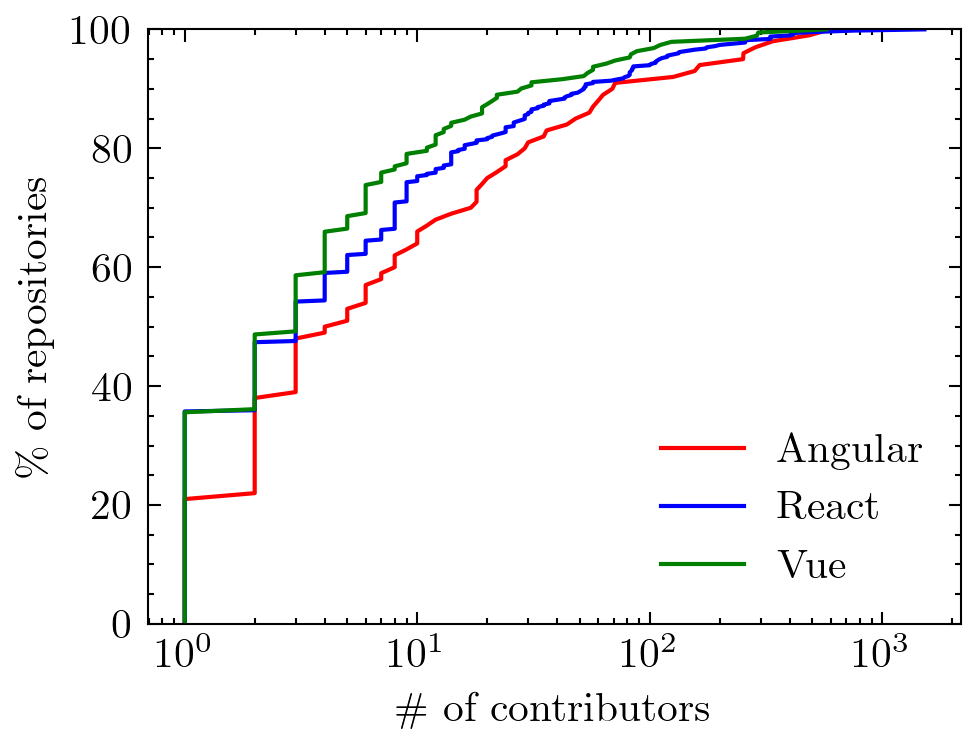

In [14]:
fig, ax = plt.subplots(dpi=300)
plt.xscale('log')

for wf, color in zip(WEBFRAMEWORKS, COLORS):
    x = sorted(contrib_dist[wf])
    y = np.linspace(0, 100, len(x))
    ax.plot(x, y, label=wf, color=color)

ax.set_xlabel("\# of contributors")
ax.set_ylabel("\% of repositories")
ax.legend(loc='lower right')
ax.set_ylim([0, 100])
fig.show()
fig.savefig('../plots/cdf-rq2-contributors.pdf', transparent = True, bbox_inches = 'tight', dpi=300)

In [15]:
update_macro('kstestvueangularcontributors', ks_test(contrib_dist['Vue'], contrib_dist['Angular']))
update_macro('kstestreactangularcontributors', ks_test(contrib_dist['React'], contrib_dist['Angular']))
update_macro('kstestvuereactcontributors', ks_test(contrib_dist['Vue'], contrib_dist['React']))

### By SLOC

In [16]:
with open('../data/sloc.json') as f:
    sloc = json.load(f)

In [17]:
def get_sloc_by_commit_id(repo, commit_id):
    repo_path = get_repository_path(repo)
    git = Repo(repo_path)
    branch = git.active_branch.name
    git.git.checkout(commit_id)
    proc = subprocess.run(['/home/mharoon/.opt/nodejs/bin/sloc', '-f', 'json', repo_path], stdout=subprocess.PIPE)
    git.git.checkout(branch)
    try:
        return json.loads(proc.stdout)
    except:
        print(repo.name)
        return {}

In [18]:
for repo in tqdm(repos):
    if repo.name in sloc:
        continue
    sloc[repo.name] = get_sloc_by_commit_id(repo, ci_introduction[repo.name])
    
with open('../data/sloc.json', 'w') as f:
    json.dump(sloc, f)

  0%|          | 0/792 [00:00<?, ?it/s]

In [19]:
def get_sloc(repo):
    if repo.name in sloc:
        if 'summary' in sloc[repo.name]:
            if 'total' in sloc[repo.name]['summary']:
                return sloc[repo.name]['summary']['total']
            return 0
    return None

In [20]:
distributions = {}
for repo in tqdm(repos):
    wf = get_webframework(repo)
    git = Repo(get_repository_path(repo))

    if wf not in distributions:
        distributions[wf] = []
    
    loc = get_sloc(repo)
    if loc is not None:
        distributions[wf].append(loc)

  0%|          | 0/792 [00:00<?, ?it/s]

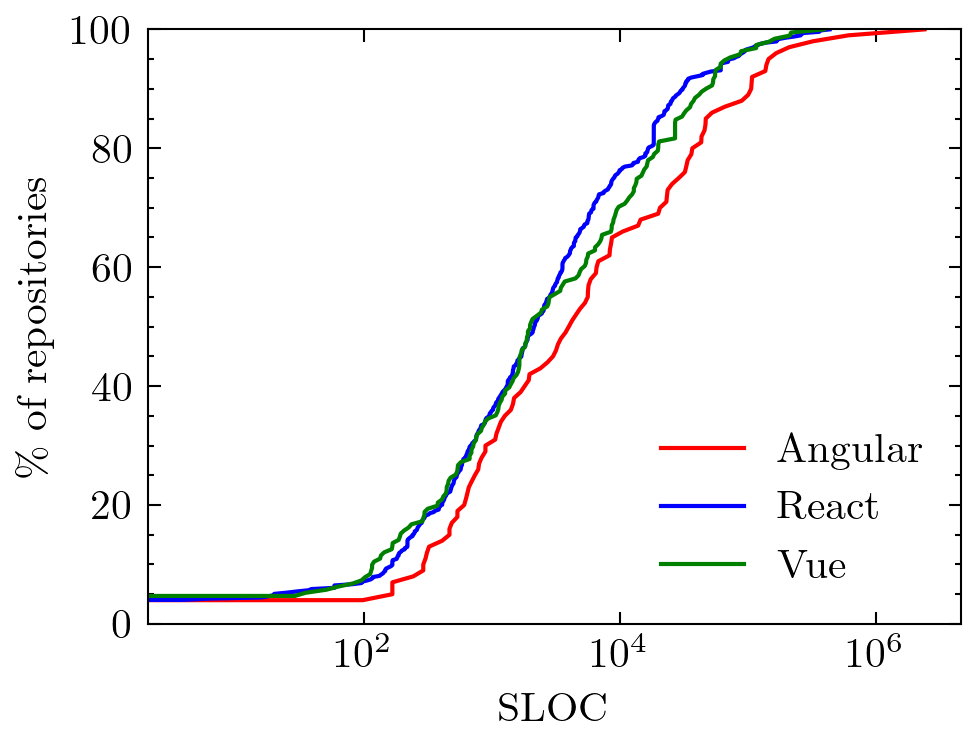

In [21]:
fig, ax = plt.subplots(dpi=300)
plt.xscale('log')

for wf, color in zip(WEBFRAMEWORKS, COLORS):
    x = sorted(distributions[wf])
    y = np.linspace(0, 100, len(x))
    ax.plot(x, y, label=wf, color=color)

ax.set_xlabel("SLOC")
ax.set_ylabel("\% of repositories")
ax.set_ylim([0, 100])
ax.legend(loc='lower right')
fig.show()
fig.savefig('../plots/cdf-rq2-sloc.pdf', transparent = True, bbox_inches = 'tight', dpi=300)

In [22]:
update_macro('kstestvueangularsloc', ks_test(distributions['Vue'], distributions['Angular']))
update_macro('kstestreactangularsloc', ks_test(distributions['React'], distributions['Angular']))
update_macro('kstestvuereactsloc', ks_test(distributions['Vue'], distributions['React']))